In [61]:
# import packages
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
from datetime import timedelta
import matplotlib.pyplot as plt

In [62]:
relax_eng = pd.read_csv('takehome_user_engagement.csv', parse_dates=['time_stamp'])
relax_user = pd.read_csv('takehome_users.csv')

In [63]:
relax_eng.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [64]:
relax_user.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [65]:
relax_eng.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
 2   visited     207917 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


In [66]:
relax_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


<h1>Data Wrangling</h1>

In [67]:
#Put time stamp in user engagement table into index column
relax_eng.index = relax_eng.time_stamp

In [68]:
#Convert last_session_creation_time column in user table to datetime
relax_user['last_session_creation_time'] = pd.to_datetime(relax_user['last_session_creation_time'], unit='s')
relax_user['last_session_creation_time'] = relax_user['last_session_creation_time'].fillna(relax_user.creation_time)

In [69]:
#Make function to determine whether or not user is engaged

def engaged(user):
    #Filter specific user
    eng = relax_eng[relax_eng['user_id'] == user]
    
    #Group engagements by days
    eng = eng.groupby(by=eng.time_stamp.dt.date).count()
    
    #Sort by datetime index
    eng = eng.sort_index()
    
    #Minimum of 3 days
    if eng.shape[0] >= 3:
        #days when user active
        for d in range(eng.shape[0]-3):
            #if time difference between first and third engagements is at least 7 days apart
            is_engaged = (eng.index[d+2] - eng.index[d]) <= timedelta(days=7)
            #leave loop if user engaged
            if is_engaged:
                return is_engaged
    #return default value
    return False

# create target colums: map which users have become 'engaged'
relax_user['engaged_user'] = relax_user.object_id.map(engaged)

relax_user.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,engaged_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,False
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,True
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,False
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,False
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,False


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'GUEST_INVITE'),
  Text(1, 0, 'ORG_INVITE'),
  Text(2, 0, 'SIGNUP'),
  Text(3, 0, 'PERSONAL_PROJECTS'),
  Text(4, 0, 'SIGNUP_GOOGLE_AUTH')])

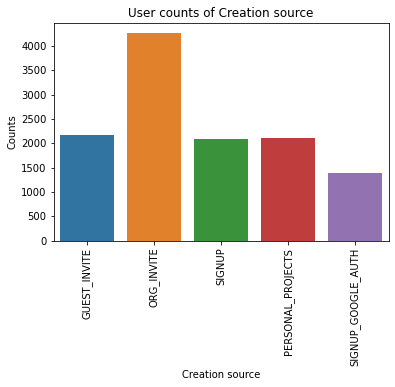

In [70]:
sns.countplot(x='creation_source', data=relax_user)
plt.title('User counts of Creation source')
plt.xlabel("Creation source")
plt.ylabel("Counts")
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'GUEST_INVITE'),
  Text(1, 0, 'ORG_INVITE'),
  Text(2, 0, 'SIGNUP'),
  Text(3, 0, 'PERSONAL_PROJECTS'),
  Text(4, 0, 'SIGNUP_GOOGLE_AUTH')])

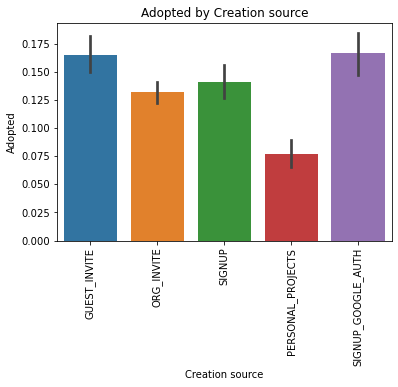

In [71]:
sns.barplot(x='creation_source', y='engaged_user', data=relax_user)
plt.title('Adopted by Creation source')
plt.xlabel("Creation source")
plt.ylabel("Adopted")
plt.xticks(rotation=90)

In [72]:
relax_user = relax_user.fillna(0)

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'GUEST_INVITE'),
  Text(1, 0, 'ORG_INVITE'),
  Text(2, 0, 'SIGNUP'),
  Text(3, 0, 'PERSONAL_PROJECTS'),
  Text(4, 0, 'SIGNUP_GOOGLE_AUTH')])

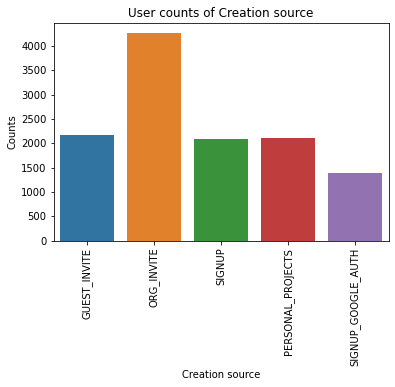

In [73]:
sns.countplot(x='creation_source', data=relax_user)
plt.title('User counts of Creation source')
plt.xlabel("Creation source")
plt.ylabel("Counts")
plt.xticks(rotation=90)

In [74]:
relax_user.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,engaged_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,False
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,True
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,False
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,False
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,False


In [75]:
#best_feat = np.abs(relax_user.corr()['engaged_user'])
best_feat_corr = pd.DataFrame(best_feat[:-1]).sort_values('engaged_user',ascending=False)
best_feat_corr = best_feat_corr.iloc[1:]
best_feat_corr

,engaged_user
invited_by_user_id,0.021460
opted_in_to_mailing_list,0.009221
enabled_for_marketing_drip,0.006984
object_id,0.004901


Text(0, 0.5, 'Features')

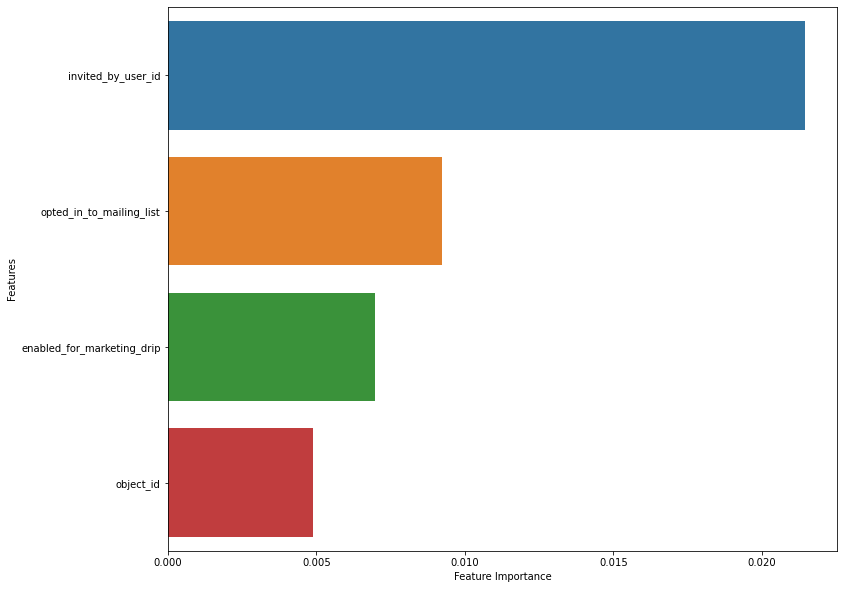

In [76]:
plt.figure(figsize=(12,10))
sns.barplot(x=best_feat_corr['engaged_user'], y=best_feat_corr.index)
plt.xlabel('Feature Importance')
plt.ylabel('Features')

The biggest factors are "invited_by_user_id", "opted_in_to_mailing_list", and "enabled_for_marketing_drip".